#### Full code for Neural Style Transfer

In [3]:

from __future__ import print_function, division
from builtins import range,input


# In this script, we will focus on generating the content
# E.g. given an image, can we recreate the same image
from keras.layers import Input,Lambda, Dense,Flatten
from keras.layers import AveragePooling2D,MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

Using TensorFlow backend.


#### Load content and style image

- can assign shape to content image

In [4]:
# load the content image

def load_img_and_preprocess(path,shape = None):
    img = image.load_img(path,target_size = shape)
    
    # convert image to array and preprocess for vgg
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis = 0)
    x = preprocess_input(x)
    
    return x

### Can Customize shape
content_img = load_img_and_preprocess('data_NST/content/content_test1.jpg',shape = (300,400))

# resize the style image
# since we don't care too much about warping it

h,w = content_img.shape[1:3]
style_img = load_img_and_preprocess('data_NST/style/dark1.jpg',(h,w))

# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]



#### Define Function

In [5]:
# we want to account for features across the entire image
# so get rid of the maxpool which throws away information
# 將max pool 換成average pool
def VGG16_AvgPool(shape):
    vgg = VGG16(input_shape =shape,weights = 'imagenet',include_top = False)
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
            
    return new_model

# there are 13 convolutions in total, we can pick any of them as the "output" of our content model
def VGG16_AvgPool_CutOff(shape,num_convs):
    if num_convs<1 or num_convs >12:
        print("num_convs must be in the range [1,13]")
        return None
    
    
    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    
    n = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n = n+1
        new_model.add(layer)
        if n >= num_convs:
            break
            
    return new_model


def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img


def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
    G = K.dot(X,K.transpose(X))/img.get_shape().num_elements()
    return G


def style_loss(y,t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))   


def minimize(fn,epochs,batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x,l,_ = fmin_l_bfgs_b(
        func = fn,
        x0 = x,
        maxfun = 20
        )
        
        x = np.clip(x,-127,127)
        print("iter = %s, loss = %s"% (i,l))
        losses.append(l)
        
    print('duration:',datetime.now() - t0)
    plt.plot(losses)
    plt.show()
    
    
    newing = x.reshape(*batch_shape)
    final_img = unpreprocess(newing)
    return final_img[0]

#### Train content and style model

- Select Conv Layer in content layer
- Select weights and layers to used in Style model

In [10]:
# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input

vgg = VGG16_AvgPool(shape)

# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
    
content_model = Model(vgg.input,vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

# create the style model
# we want multiple outputs
# pick the earlier layers for
# a more "localized" representation
# this is opposed to the content model
# where the later layers represent a more "global" structure


symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers
                        if layer.name.endswith('conv1')]

symbolic_conv_outputs = symbolic_conv_outputs[:6]

style_model = Model(vgg.input,symbolic_conv_outputs)


# make a big model that outputs multiple layers' outputs

style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses

# weight assign should correspond to symbolic_conv_outputs
style_weights = [0.8,0.7,0.5,0.7,0.6,0.8]

# create the total loss which is the sum of content + style loss

loss = K.mean(K.square(content_model.output - content_target))

for w,symbolic,actual in zip(style_weights,symbolic_conv_outputs,style_layers_outputs):
      # gram_matrix() expects a (H, W, C) as input
    loss += w*style_loss(symbolic[0],actual[0])
    
# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory

grads  = K.gradients(loss,vgg.input)

get_loss_and_grads = K.function(inputs = [vgg.input],
                               outputs = [loss]+grads)


iter = 0, loss = 13448.732421875
iter = 1, loss = 1547.838134765625
iter = 2, loss = 592.1822509765625
iter = 3, loss = 446.28973388671875
iter = 4, loss = 371.5032653808594
iter = 5, loss = 325.7658386230469
iter = 6, loss = 294.80645751953125
iter = 7, loss = 272.77874755859375
iter = 8, loss = 257.9871520996094
iter = 9, loss = 246.85899353027344
duration: 0:00:55.052598


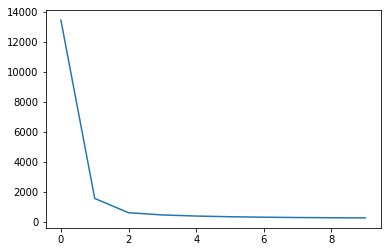

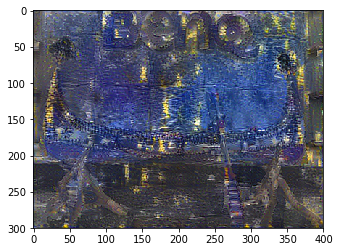

In [11]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

final_img = minimize(get_loss_and_grads_wrapper,10,batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

In [12]:
import matplotlib.image as mpimg
mpimg.imsave("out5.png", scale_img(final_img))